<h1> 
    <font color='steelblack'> <center>Étude d'un modèle de prédiction de nombre de vélos loués à chaque heure 
</h1>
<h4> <center><i>Jean-Martial TAGRO : Data Scientist </i> </center> </h4>

Le projet consiste à prévoir le nombre de vélos loués à chaque heure dans des bornes libres-services de la ville (système type Vélib'). La variable cible est ici la variable **count**.

Voici un descriptif de l'ensemble des variables :
* *datetime* - date et heure du relevé 
* *season* - 1 = printemps , 2 = été, 3 = automne, 4 = hiver 
* *holiday* – indique si le jour est un jour de vacances scolaires 
* *workingday* - indique si le jour est travaillé (ni week-end ni vacances) 
* *weather* - 1: Dégagé à nuageux, 2 : Brouillard, 3 : Légère pluie ou neige, 4 : Fortes averses ou neiges 
* *temp* – température en degrés Celsius 
* *atemp* – température ressentie en degrés Celsius 
* *humidity* – taux d’humidité 
* *windspeed* – vitesse du vent 
* *casual* - nombre de locations d’usagers non abonnés 
* *registered* – nombre de locations d’usagers abonnés 
* *count* – nombre total de locations de vélos 

L'objectif du projet est de mener à bien la création d'un modèle qui pourrait théoriquement être déployé en production. Les étapes d'exploration des données, de traitement et de preprocessing ne sont bien entendu pas à négliger. Il ne s'agit pas d'une compétition de type *Kaggle*, le projet ne sera pas uniquement noté sur la performance du modèle, mais plutôt sur votre approche complète et la justification de chacun de vos choix.

Comme vu durant le cours, soyez faites attention à certains points :
- quel type de problème dois-je traiter ?
- feature engineering : est-ce que j'utilise les données correctement, toutes les données ?
- data leakage : est-ce qu'une de mes features n'est pas trop explicative ?
- ai-je bien traité toutes les données correctement ?
- est-ce que mon modèle est adapté ?
- etc, etc, etc

Soyez vigilant à expliquer et justifier votre démarche à l'aide de visualisation, de commentaires dans vos codes (pensez aux cellules markdown), etc

---

# I. Objectif

L'objectif est de mettre en place un modèle qui prédit, avec un taux d'erreur faible, le nombre de vélos de type Vélib loués à chaque heure. Il s'agit bien d'un problème de régression en apprentissage supervisé. 
Il ne s'agit pas de faire une étude de série temporelle même si on a la notion de <strong> temps </strong>, mais bien de prédire le nombre d'emprunts de vélos en fonction de différentes caractéristiques (associées ici à une heure)

In [77]:
# Importations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, SelectFromModel, SelectKBest, VarianceThreshold, RFECV, f_classif
from sklearn.metrics import r2_score

In [6]:
# get dataset
data = pd.read_csv(os.getcwd()+'/velo.csv')

---

# II. Exploratory Data Analysis - EDA

## Objectif de l'EDA :
- Comprendre du mieux possible nos données en vue d'un bon preprocessing et d'une bonne modélisation.

- Cette partie résume les notes, observations obtenues suite à l'analye du jeu de données.

## Checklist de base

#### Analyse de Forme et de fond :

- **variable target** : count (quantitaive discrète)
- **lignes et colonnes** : (10886, 11)
- **types de variables** : 
    <br> **var qualitatives encodées en quantitatives discrètes** 4 : season, holiday, workingday, weather
    <br> **var quantitatives continues** : 4 : temp, atemp, humidity, windspeed
    <br> **var quantitatives continues (natives)** : 2 : casual, registered


- **Analyse des valeurs manquantes** : Le dataset est 100% renseigné : pas de NaN
 
    
- **Visualisation de la target** : count (nombre de vélos loués): 822 uniques valeurs; <br> Le count élovue globalement vers la hausse entre janvier 2011 et janvier 2012


 **Signification des variables** : A. VAR QUANTITATIVES :   //  B. VAR QUALITATIVES :
la variable 'model_label' est textuelle --> Nous allons faire un Word2Vec sur cette colonne

 **Relation Variables / Target** :
 - 'registered' très colinéaire à count : le nombre d'emprunt semble être très lié au nombre de locations d’usagers abonnés en particulier.
 
 **Relation Variables / Variable**  : 
 - temp et atemps sont très colinéaires : il s'agit de la temperature et du ressenti --> Potentiel effet de multicolinéarité : supprimer une ?

---

In [26]:
df = data.copy()
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Un peu d'analyse temporelle

On va importer le dataset en réglant la colonne datetime en une DateTime Index pour permettre à Pandas de bien interpréter les dates et observer l'évolution temporelle du nombre d'emprunts :

In [27]:
# get dataset - timeseries
data_temp = pd.read_csv(os.getcwd()+'/velo.csv', index_col='datetime', parse_dates=True)

In [28]:
# on verifie
temp = data_temp.copy()
print(df.shape)
print('Index type : ', type(temp.index))
temp.head()

(10886, 12)
Index type :  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<AxesSubplot:xlabel='datetime'>

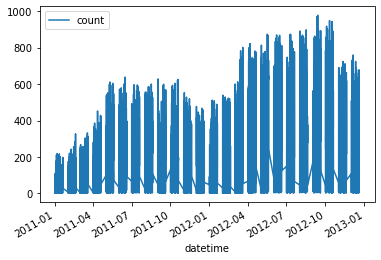

In [29]:
# Observons le nombre de vélos loués en fonction de l'heure sur tout le dataset :
temp.loc[:, ['count']].plot()

On note une augmentation globale du nombre de vélos empruntés entre Janvier 2011 et décembre 2012.<br>
Regardons l'evolution de la moyenne mensuelle du nombre d'emprunts par année (2011, 2012) :

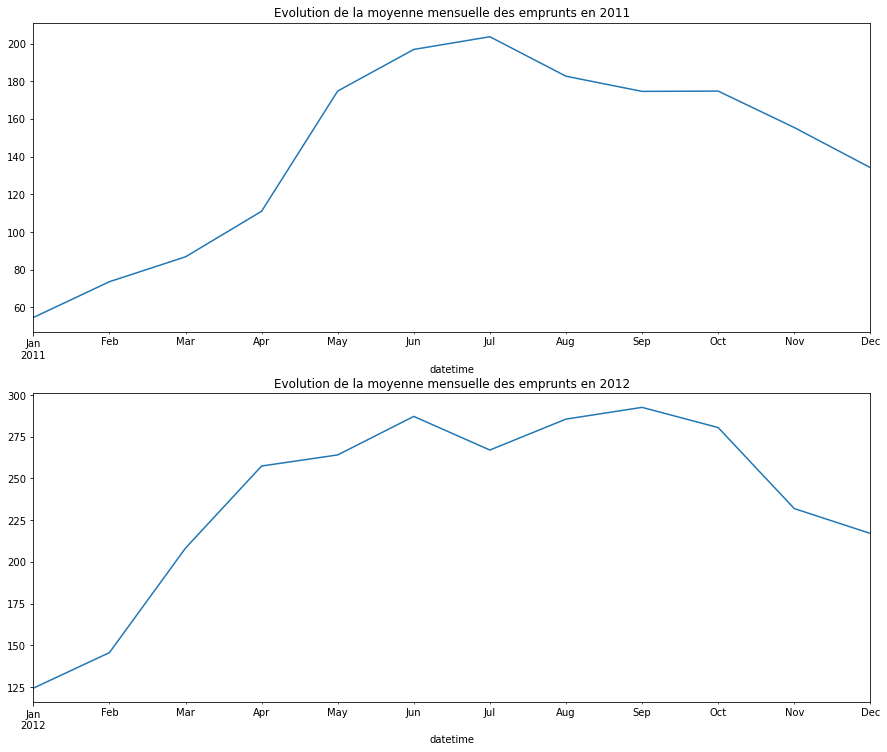

In [30]:
plt.figure(figsize=(15,12.5))
index = 1
for an in ['2011', '2012']:
    plt.subplot(2,1, index)
    plt.title('Evolution de la moyenne mensuelle des emprunts en {}'.format(an))
    temp.loc[an, 'count'].resample('M').mean().plot()
    index += 1

## Revenons à notre problème de regression

On va analyser les corrélations entre les variables et avec la target count.

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


<AxesSubplot:ylabel='None'>

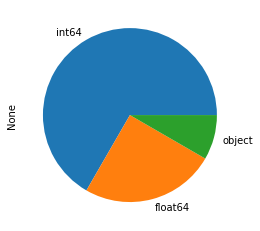

In [31]:
print(df.dtypes)
df.dtypes.value_counts().plot.pie()

#### Analysons les valeurs uniques et manquantes du dataset

In [32]:
# Analyse niveau % de completion et des valeurs uniques
for col in df.columns:
    print(f'{col:-<25} {df[col].nunique():-<30} {df[col].isna().sum()/temp.shape[0]}')

datetime----------------- 10886------------------------- 0.0
season------------------- 4----------------------------- 0.0
holiday------------------ 2----------------------------- 0.0
workingday--------------- 2----------------------------- 0.0
weather------------------ 4----------------------------- 0.0
temp--------------------- 49---------------------------- 0.0
atemp-------------------- 60---------------------------- 0.0
humidity----------------- 89---------------------------- 0.0
windspeed---------------- 28---------------------------- 0.0
casual------------------- 309--------------------------- 0.0
registered--------------- 731--------------------------- 0.0
count-------------------- 822--------------------------- 0.0


Toutes ces variables ont donc au moins 2 valeurs différentes. Ce qui veut dire qu'il peuvent apporter de l'information pertinente pour notre problèmatique; puisqu'elles ont toutes une variance non nulle.

On constate aussi que toutes les colonnes du dataset sont renseignés à 100%, on aura donc pas de problème de valeurs manquantes.

En outre, datetime n'est pas pertinent comme information : il y a autant de valeurs différentes que de lignes dans le dataset. On va le supprimer puis passer à l'analyse des corrélations feature/target et feature/feature.

In [33]:
df.drop('datetime', axis=1, inplace=True)

In [34]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [35]:
col_int = ['casual', 'registered', 'humidity', 'count']
col_float = ['temp', 'atemp', 'windspeed']
col_cat = ['season', 'holiday', 'workingday', 'weather']

## Analyse univariée

#### Distribution des variables quantitatives discrètes et continues

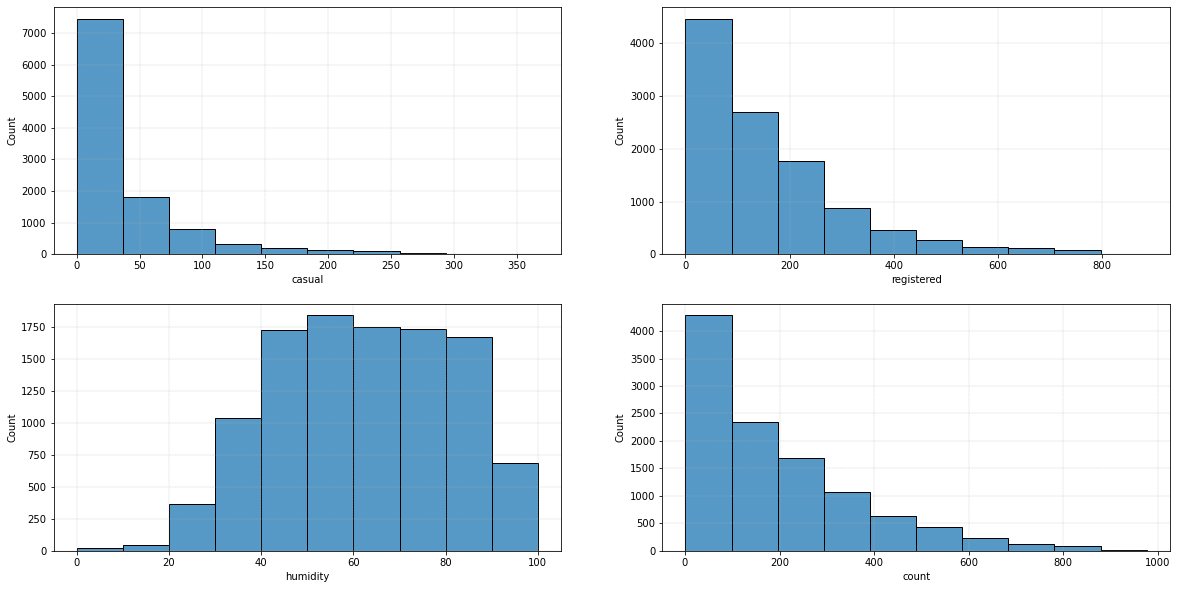

In [36]:
plt.figure(figsize = (20,10))
for index, col in enumerate(col_int):
    plt.subplot(2,2,index+1)
    plt.grid(linestyle='--', linewidth=0.3)
    sns.histplot(df[col], bins = 10)

La variable 'Humidity' semble suivre une distribution gaussienne mais asymétrique. 

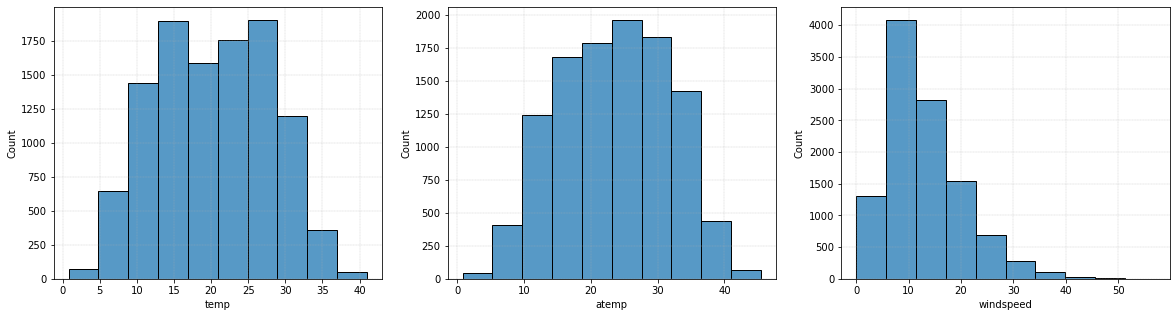

In [37]:
plt.figure(figsize = (20,5))
for index, col in enumerate(col_float):
    plt.subplot(1,3,index+1)
    plt.grid(linestyle='--', linewidth=0.3)
    sns.histplot(df[col], bins = 10)

Les variables quantitatives continues semblemt suivre une distribution gaussienne qui pourrait être intéressant pour notre modélisation. <br>
On note aussi que toute ces variables sont globalement sur la même échelle. On ne pas faire de feature scaling.

#### Distributions des variables qualitatives

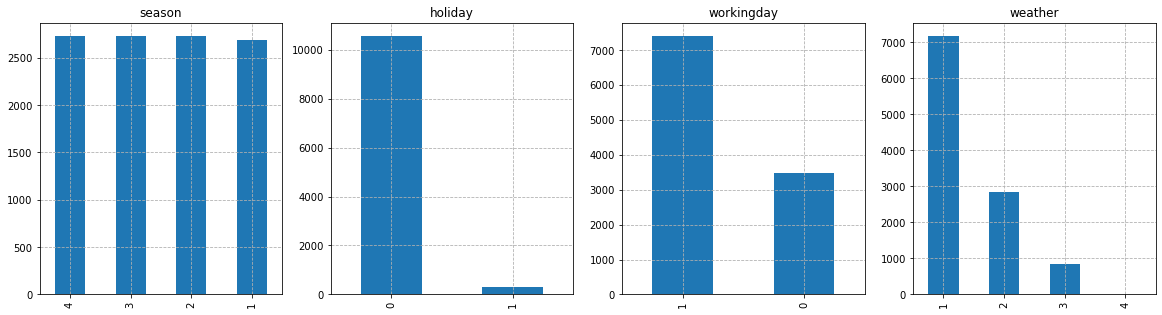

In [38]:
plt.figure(figsize = (20,5))
for index, col in enumerate(col_cat):
    plt.subplot(1,4,index+1)
    df[col].value_counts().plot.bar()
    plt.grid(linestyle='--', linewidth=0.8)
    plt.title(col)

Seules les modalités de la variable catégorielle 'Saison' sont équilibrées.

## Analyse bivariée

### Analysons les corrélations entre les features numériques et la target 'count'

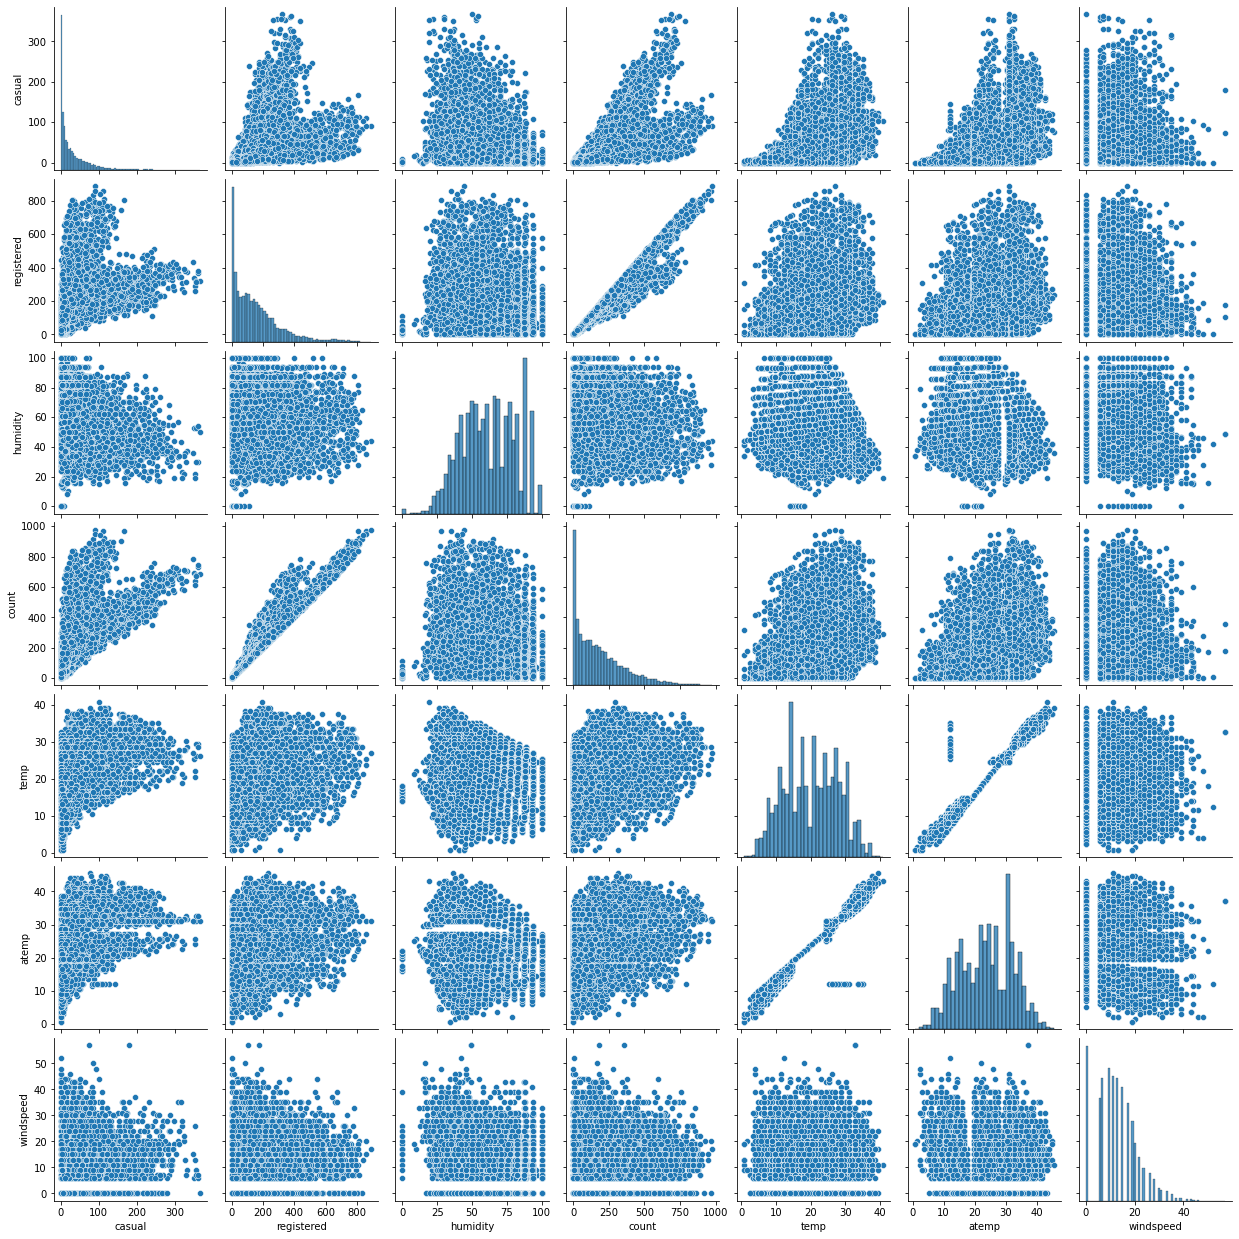

In [39]:
sns.pairplot(data = df[col_int+col_float])

On note une interessante remarque qui est le fait que la variable 'registered' semble être très correlées avec le nombre d'emprunt 'count'.
- Quand on regarde cette variable, on se dit c'est quasiment la même (ou presque). En fait, naturellement, le nombre d'emprunts total = nombre d'emprunts des abonnés (registered) + nombre d'emprunts des non abonnés (casual).
- Il va falloir retirer donc une de ces variables pour eviter ce problème de colinéarité qui biaiserait gravement la performance du modèle.

Aussi, les features 'temp' et 'atemp' sont très correlés entre eux : Normal puisqu'il s'agit respectivement de la température en degrés Celsius et de la température ressentie en degrés Celsius. 
On note juste quelques exceptions dûes peut-être à certaines régions proches de la mer où le ressenti et different de la temperature.
<br>On devra peut-être supprimer une de ces variables pour éviter de mauvais effets de multicolinéarité.

On peut vérifier autrement :

<AxesSubplot:>

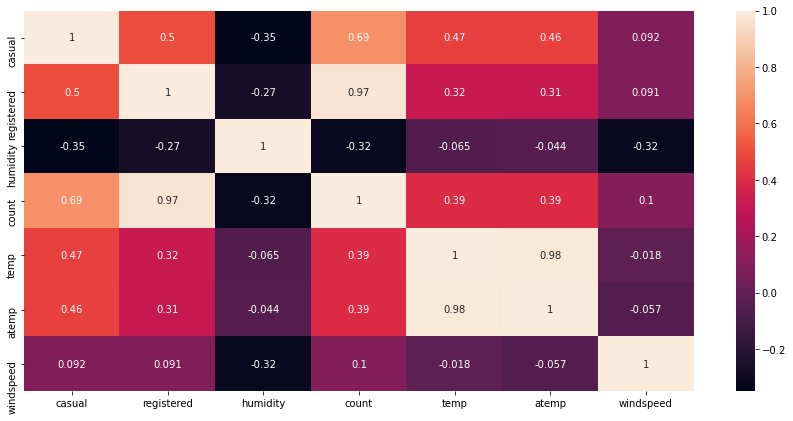

In [41]:
plt.figure(figsize=(15,7))
sns.heatmap(df[col_int+col_float].corr(), annot=True)

On a :

<AxesSubplot:>

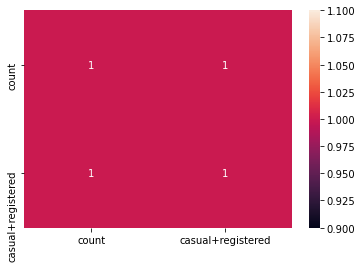

In [42]:
# on fait la somme de 'registered' et 'casual' et evalue la correlation de cette somme avec 'count'
df['casual+registered'] = df['casual']+df['registered']
sns.heatmap(df[['count','casual+registered']].corr(), annot=True)

- On s'y attendait ! count est exactement = casual+registered. 
- On va donc supprimer des features 'casual' et garder 'registered' - plus corrélé à 'count' - et aussi sans oublier de supprimer 'casual+registered' qu'on vient de créer pour le test :

In [43]:
df.drop(['casual', 'casual+registered'], axis=1, inplace=True)

### features catégorielles / count

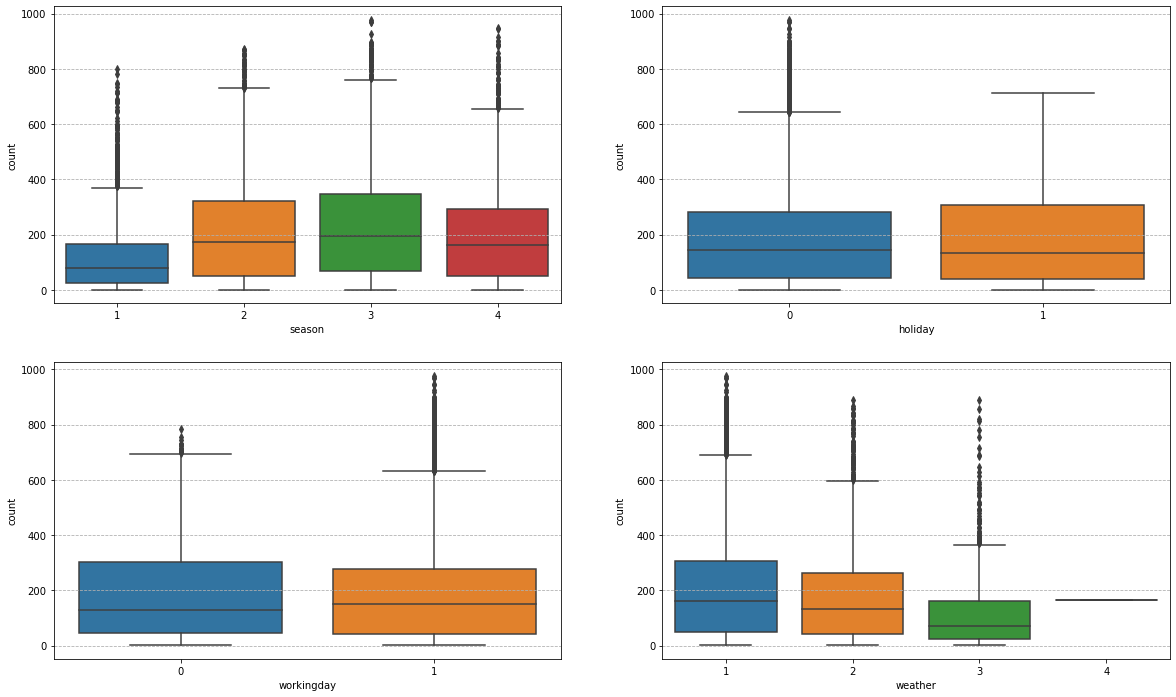

In [44]:
plt.figure(figsize = (20,12))
for index, col in enumerate(col_cat):
    plt.subplot(2,2,index+1)
    plt.grid(linestyle='--', linewidth=0.8)
    sns.boxplot(x=df[col], y=df['count'])

- Evidemment aucun emprunt de vélos en weather 4 : Fortes averses ou neiges
- Le nombre d'emprunts de velos semble ne pas être semblibles à 1ere vue, ni au type de jour (travaillé ou vacance)
- 'Season' et 'weather' semblent etre interessantes car on note plus variance plus importante du nombre d'emprunts.

---

# III. Pre-processing

D'après l'EDA, 
- Le jeu de données a ses variables catégoriques déjà encodées. pas besoin d'encoder
- Toutes les variables quantitatives sont globalement sur la même échelle. On ne pas faire de normalisation.
- Le jeu est bien renseigné : pas de NaN

On va séraper le jeu de donnée en train et test :

In [46]:
# X et y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Separation en train et Test set
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1).ravel(), test_size=0.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7620, 9), (3266, 9), (7620,), (3266,))

# IV. Modélisation

### Recherche du meilleur modèle sous-jacent à notre problématique

In [65]:
# construction de modèles
decisionTree = DecisionTreeClassifier(random_state=0)
randomForest = RandomForestClassifier(random_state=0)
svc = SVC(random_state=0)
knn = KNeighborsClassifier()
reg = LinearRegression()
elastic = ElasticNet(random_state=0)

# cree dictionnaire des modèles
models = {
         'Decision Tree':decisionTree,
         'Random Forest': randomForest,
         'SVC': svc,
         'KNN': knn,
         'Linear Regression':reg,
         'Elastic Net': elastic
         }

# V. Évaluation

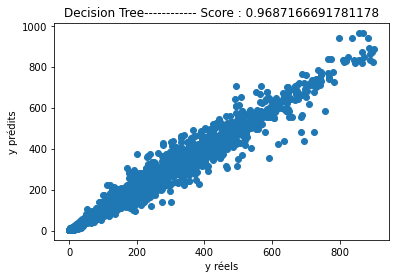

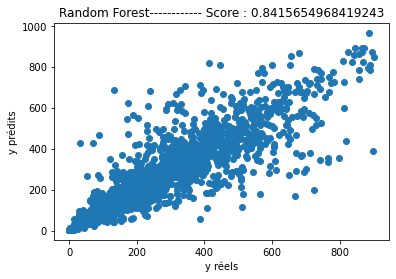

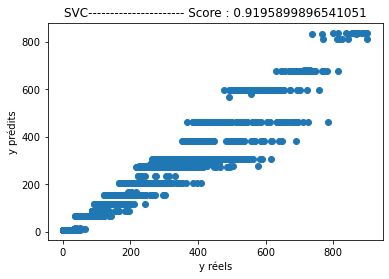

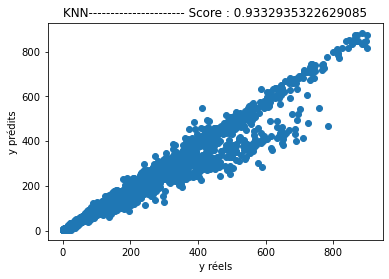

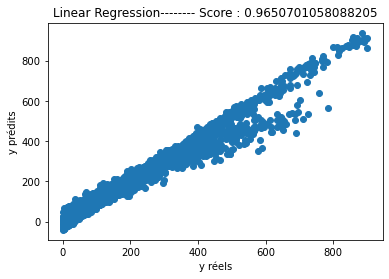

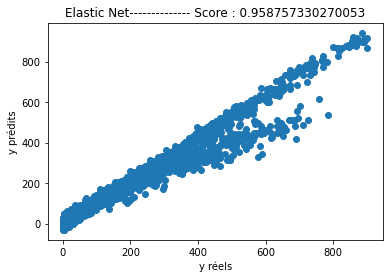

In [67]:
for name, model in models.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.title(f'{name:-<25} Score : {r2_score(y_test, y_pred)}')
    plt.xlabel('y réels')
    plt.ylabel('y prédits')
    plt.show()


On a déjà une performance de r2 score intéressante sur le jeu de test pour la plapart des modèles testés (le KNN performe beaucoup moins).<br> 
Tentons d'optimiser l'Elastic Net qui tire l'avantage des modèles de reression Ridge et du Lasso, en optimisant ses hyper-paramètres de régularisation :

# VI. Optimisation de l'Elastic Net

In [68]:
# visualisation des paramètres
elastic.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [72]:
params = {'alpha': np.linspace(0.5, 2, 10), 
          'l1_ratio': [0.25, 0.5, 0.75]
         }

grid = GridSearchCV(elastic, 
                            param_grid=params,
                            scoring='r2',
                            cv=5
                           )

grid.fit(X_train, y_train)
print('best parameters : ',grid.best_params_)

best parameters :  {'alpha': 0.5, 'l1_ratio': 0.75}


In [74]:
# On cree le modele avec les meilleurs hyperparamètres et on l'entraîne
elastic_opt = ElasticNet(alpha=0.5, l1_ratio=0.75)
elastic_opt.fit(X_train, y_train)

ElasticNet(alpha=0.5, l1_ratio=0.75)

## Evaluation

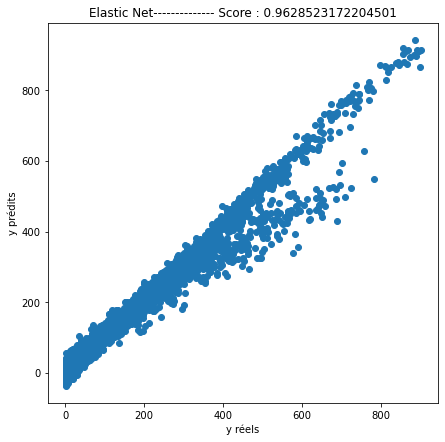

In [75]:
y_predict = elastic_opt.predict(X_test)

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_predict)
plt.title(f'{name:-<25} Score : {r2_score(y_test, y_predict)}')
plt.xlabel('y réels')
plt.ylabel('y prédits')
plt.show()

On obtient avec Grid Search une meilleure performance (96,28 %) sur le score r2 que précédemment (95,87 %) mais un tout petit peu moins que l'arbre de décision avec un score r2 de 96,87 %

Comparons ces deux modèles : Decision Tree et Elastic net (optimisé via grid search). <br>
On va vérifier via une fonction procédure d'évaluation si les performances de ces modèles sont prometteurs c'est-à-dire leur capacité à généraliser.

## Procédure d'évaluation

In [89]:
def evaluation(model):

    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                              scoring='r2',
                                              train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12,5))
    plt.grid(linestyle='--', linewidth=0.8)
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='val score')
    plt.title(model)
    plt.legend()

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


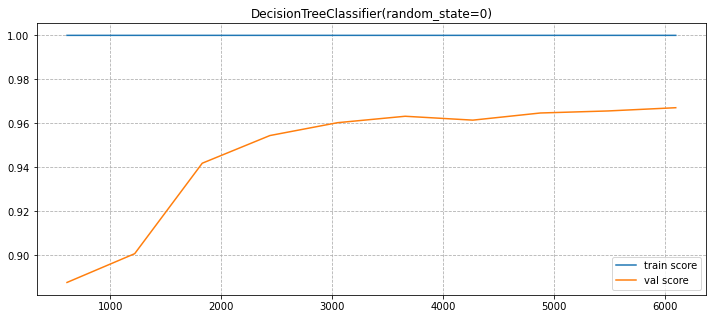

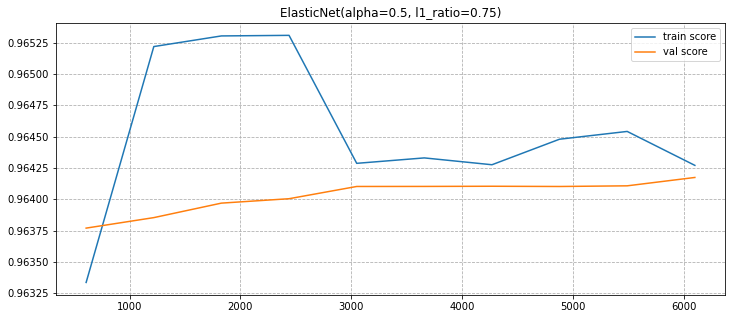

In [90]:
evaluation(decisionTree)
evaluation(elastic_opt)

Intéressant : On voit clairement que l'arbre de décision à un score r2 de 100% sur le jeu d'entrainement. <br>
Les deux modèles ont un peu plus de 96% de performance; mais l'Elastic net est moins collé au jeu d'entraînement : ces courbes d'entraînement et de validation sont mieux alignés (rapprochées).<br><br>
<h1> Conclusion </h1>
<h3>On choisit par conséquent le modèle Elastic Net : elastic_opt comme modèle à mettre en production car il a <br> <br>mieux tendance à généraliser.</h3>

---